In [ ]:
import pandas as pd

df = pd.read_excel (r'C:\Users\kkanoee\Documents\Python Scripts\TablePython.xlsx') #place "r" before the path string to address special character, such as '\'. Don't forget to put the file name at the end of the path + '.xlsx'
print (df)
df.iat[0,1]

for ind in df.index:
    print(df['CollectionList'][ind], df['TokenList'][ind], df['Tokenperday'][ind])
    print('next')
    
    apicall='https://api-mainnet.magiceden.dev/v2/collections/'+df['CollectionList'][ind]+'/stats/'
    print(apicall)
    

In [ ]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json


column_names = ["symbol", "floorPrice", "listedCount", "avgPrice24hr", "volumeAll"]
dfAfp = pd.DataFrame(columns = column_names)

column_token = ['timestamp', 'error_code', 'error_message','elapsed', 'credit_count', 'notice','id', 'name', 'symbol','slug', 'num_market_pairs', 'date_added','tags', 'max_supply', 'circulating_supply','total_supply', 'id', 'name','symbol', 'platform_slug', 'platform_token_address','is_active', 'cmc_rank', 'is_fiat','self_reported_circulating_supply', 'self_reported_market_cap', 'tbl_ratio','last_updated', 'usd_price', 'usd_volume_24h','usd_volume_change_24h', 'usd_percent_change_1h', 'usd_percent_change_24h','usd_percent_change_7d', 'usd_percent_change_30d', 'usd_percent_change_60d','usd_percent_change_90d', 'usd_marketcap', 'usd_marketcap_dominance','usd_full_diluted_marketcap', 'usd_tvl', 'usd_last_updated', 'token_per_day', 'usd_per_day']
dfA = pd.DataFrame(columns = column_token)
dfA = dfA.reset_index(drop=True)

for ind in df.index:
    print(df['CollectionList'][ind], df['TokenList'][ind], df['Tokenperday'][ind])
    print('next')

    #Collection -------------------------------------------------------------
    
    apicall='https://api-mainnet.magiceden.dev/v2/collections/'+df['CollectionList'][ind]+'/stats/'
    
    url = apicall
    headers = {
      'Accepts': 'application/json',
      'X-CMC_PRO_API_KEY': '0fbe4952-0675-4f13-8274-fb02dbd99dbf',
    }

    session = Session()
    session.headers.update(headers)

    try:
      response = session.get(url)
      FloorPrice = json.loads(response.text)
      #print(FloorPrice)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
      print(e)

    df1fp = pd.json_normalize(FloorPrice)
    dfAfp = pd.concat([dfAfp, df1fp], ignore_index=True, sort=False)
    
    #Tokens -----------------------------------------------------------------
    
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest'
    parameters = {
      'convert':'USD',
    'symbol':df['TokenList'][ind]
    }
    headers = {
      'Accepts': 'application/json',
      'X-CMC_PRO_API_KEY': '0fbe4952-0675-4f13-8274-fb02dbd99dbf',
    }

    session = Session()
    session.headers.update(headers)

    try:
      response = session.get(url, params=parameters)
      Token = json.loads(response.text)
      #print(Token)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
      print(e)
    
    df1 = pd.json_normalize(Token)
    df1.columns = ['timestamp', 'error_code', 'error_message','elapsed', 'credit_count', 'notice','id', 'name', 'symbol','slug', 'num_market_pairs', 'date_added','tags', 'max_supply', 'circulating_supply','total_supply', 'id', 'name','symbol', 'platform_slug', 'platform_token_address','is_active', 'cmc_rank', 'is_fiat','self_reported_circulating_supply', 'self_reported_market_cap', 'tbl_ratio','last_updated', 'usd_price', 'usd_volume_24h','usd_volume_change_24h', 'usd_percent_change_1h', 'usd_percent_change_24h','usd_percent_change_7d', 'usd_percent_change_30d', 'usd_percent_change_60d','usd_percent_change_90d', 'usd_marketcap', 'usd_marketcap_dominance','usd_full_diluted_marketcap', 'usd_tvl', 'usd_last_updated']
    df1.loc[0,'token_per_day']=df['Tokenperday'][ind]
    df1['usd_per_day']=df1['usd_price']*df1['token_per_day']
    
    df1.reset_index(inplace=True, drop=True)
    dfA.reset_index(inplace=True, drop=True)
    dfA = pd.concat([dfA, df1], ignore_index=True, sort=False)


In [ ]:
dfA

In [ ]:

# this let us see all columns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Correct ME values

dfAfp2 = dfAfp
dfAfp2.floorPrice = dfAfp.floorPrice/1000000000
dfAfp2.avgPrice24hr = dfAfp.avgPrice24hr/1000000000
dfAfp2.volumeAll = dfAfp.volumeAll/1000000000
dfAfp2

In [ ]:

# CALL SOL and grab its price

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest'
parameters = {
  'convert':'USD',
    'symbol':'SOL'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': '0fbe4952-0675-4f13-8274-fb02dbd99dbf',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  SOL = json.loads(response.text)
  #print(SOL)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

df0 = pd.json_normalize(SOL)
df0['data.SOL.quote.USD.price']

SOLPRICE = df0.iat[0,24]

SOLPRICE


In [ ]:
#CONCAT BOTH TOKENS PRICE AND FLOOR PRICE

dfTABLE = dfA
dfTABLE['Symbol'] = dfAfp.symbol
dfTABLE['floorPrice'] = dfAfp.floorPrice
dfTABLE['floorPriceUSD'] = dfAfp["floorPrice"]*SOLPRICE
dfTABLE['ROI days']=dfTABLE['floorPriceUSD']/dfTABLE['usd_per_day']


dfTABLE



In [93]:
import os   

if not os.path.isfile(r'C:\Users\kkanoee\Documents\Python Scripts\SOLTOKENS.csv'):
    dfA.to_csv(r'C:\Users\kkanoee\Documents\Python Scripts\SOLTOKENS.csv', header='column_names')
else: dfA.to_csv(r'C:\Users\kkanoee\Documents\Python Scripts\SOLTOKENS.csv', mode='a', header=False)

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

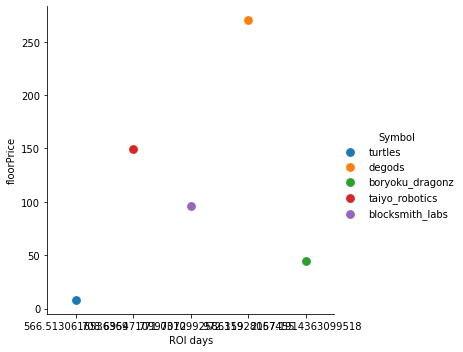

In [95]:
splot = sns.catplot(x='ROI days',
                    y='floorPrice',
                    hue='Symbol',
                    data=dfTABLE.round(),
                    kind='point',
                    fit_reg=False,
                    aspect=1)

splot
#splot.set(xscale="log")

In [96]:
import os   

if not os.path.isfile(r'C:\Users\kkanoee\Documents\Python Scripts\SOLTOKENS.xlsx'):
    dfA.to_excel(r'C:\Users\kkanoee\Documents\Python Scripts\SOLTOKENS.xlsx', header='column_names')
else: dfA.to_excel(r'C:\Users\kkanoee\Documents\Python Scripts\SOLTOKENS.xslx', mode='a', header=False)